In [1]:
import json
import os

from pdf2image import convert_from_path
from easydict import EasyDict as edict
from navertrans import navertrans
import matplotlib.pyplot as plt
from easyocr import Reader
from bardapi import Bard
import numpy as np
import cv2

![Python](https://img.shields.io/badge/python-3670A0?style=for-the-badge&logo=python&logoColor=ffdd54)
![OpenCV](https://img.shields.io/badge/opencv-%23white.svg?style=for-the-badge&logo=opencv&logoColor=white)
![NumPy](https://img.shields.io/badge/numpy-%23013243.svg?style=for-the-badge&logo=numpy&logoColor=white)
![Matplotlib](https://img.shields.io/badge/Matplotlib-%23ffffff.svg?style=for-the-badge&logo=Matplotlib&logoColor=black)
![Jupyter Notebook](https://img.shields.io/badge/jupyter-%23FA0F00.svg?style=for-the-badge&logo=jupyter&logoColor=white)
![BardAPI](https://img.shields.io/badge/pypi-BardAPI-black)

In [2]:
ROOT_PATH   = '/'.join(os.getcwd().split(os.path.sep)[:-6])
CONFIG_PATH = f'{ROOT_PATH}/utils/config.json'
CONFIG      = edict(json.loads(open(CONFIG_PATH, 'r').read()))

os.environ['_BARD_API_KEY'] = CONFIG.bard

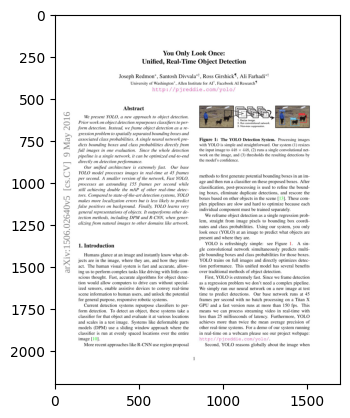

In [3]:
pages  = convert_from_path('yolo v1.pdf', fmt = 'jpg')
plt.imshow(pages[0])

In [4]:
def get_reader(lang, is_gpu = False):

    lang = [lang] if isinstance(lang, str) else lang
    return Reader(lang_list = lang, gpu = is_gpu)
    

## 페이지에 있는 figure나 table을 가려주는 함수 
## figure나 table에 글자가 있는 경우에 OCR이 읽어 문장이 이상해지는 경우가 있어 만듦.
def get_masked_page(image, need_rect = False):
    
    image    = np.array(image)
    image_cp = image.copy()
    
    gray     = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, bin_  = cv2.threshold(gray, 210, 255, cv2.THRESH_BINARY)
    
    H, W     = image.shape[:2]

    ## 페이지 내 글씨 이외의 figure나 table의 contour를 찾음.
    conts, _ = cv2.findContours(bin_, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
    areas    = [cv2.contourArea(cont) for cont in conts]
    conts    = [(area, cont) for area, cont in zip(areas, conts) 
                if 1_000 < area < H * W - 5_000]
    
    if conts:
        conts = sorted(conts, key = lambda x: x[0], reverse = True)
        for _, cont in conts:
            x, y, w, h = cv2.boundingRect(cont)
            
            cv2.rectangle(image_cp, (x, y), (x + w, y + h), (0, 255, 0), 15)
            cv2.rectangle(gray, (x - 10, y - 15), (x + (w + 10), y + (h + 15)), (0, 0, 0), -1)
    
    if need_rect:  return gray, image_cp
    
    return gray


## OCR을 이용하여 이미지에 있는 글자들을 읽어주는 함수
def read_text(image):
    
    results = reader.readtext(image)
    texts   = ' '.join([text[1] for text in results if len(text[1]) != 1])
    
    return texts


def show_pages(pages):
    _, axes = plt.subplots(1, 3, figsize = (17, 5))
    
    for idx, (ax, page) in enumerate(zip(axes, pages)):
        ax.imshow(page, cmap = 'gray' if idx == 1 else None)
        ax.axis(False)


## Daniel Park 님께서 만들어주신 BardAPI를 통해 번역해주는 함수 
## https://github.com/dsdanielpark/Bard-API (GOAT)
def translate(prompt):
    
    prompt = f'다음 문장 한국어로 번역 해줘 {prompt}'  
    return Bard(timeout = 15).get_answer(prompt)


def naver_translate(prompt):

    return navertrans.translate(prompt, src_lan = 'en', tar_lan = 'ko')

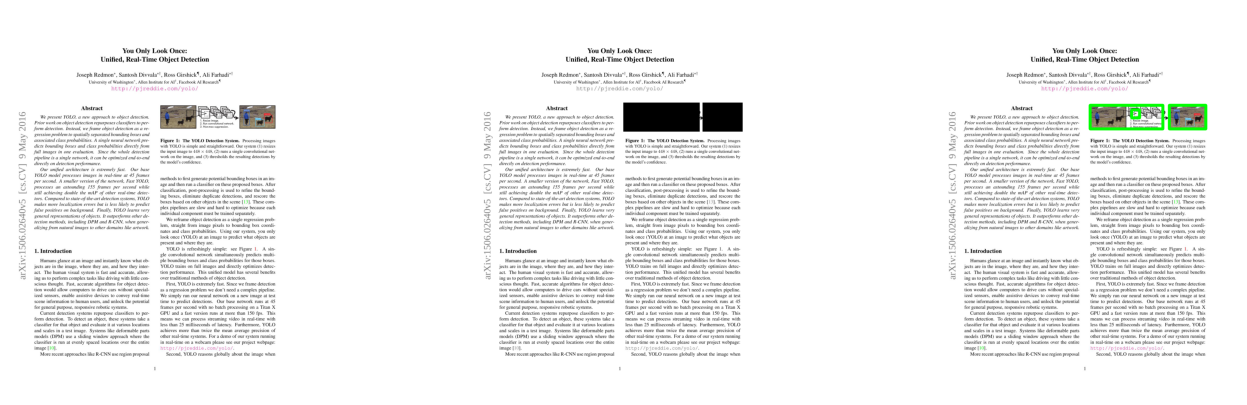

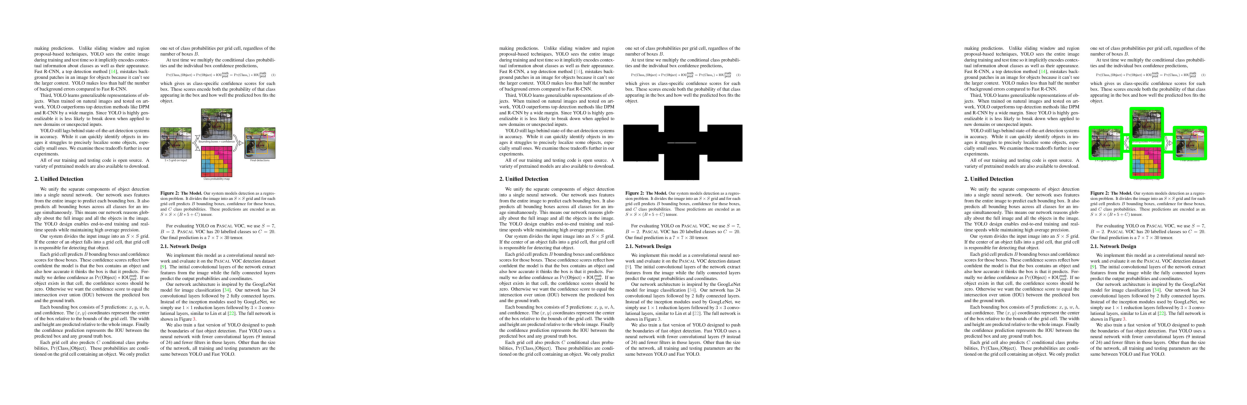

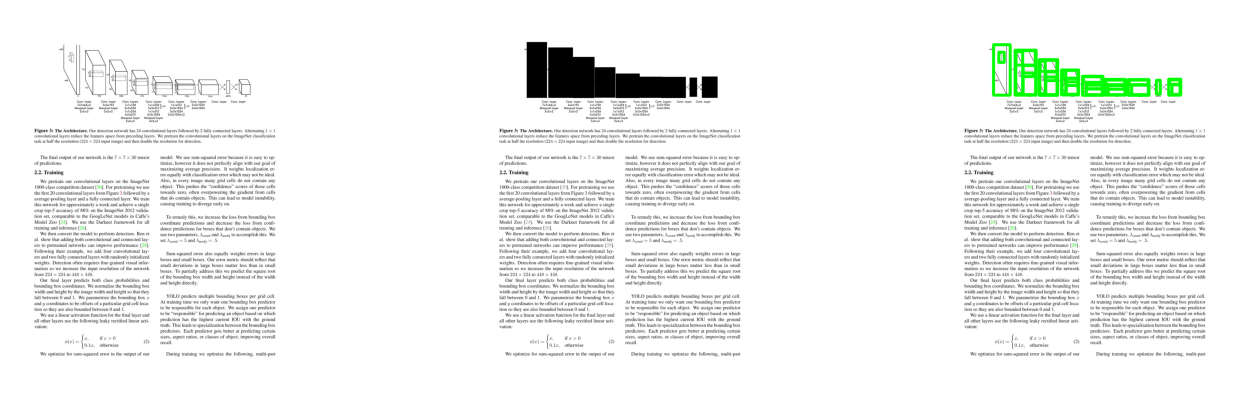

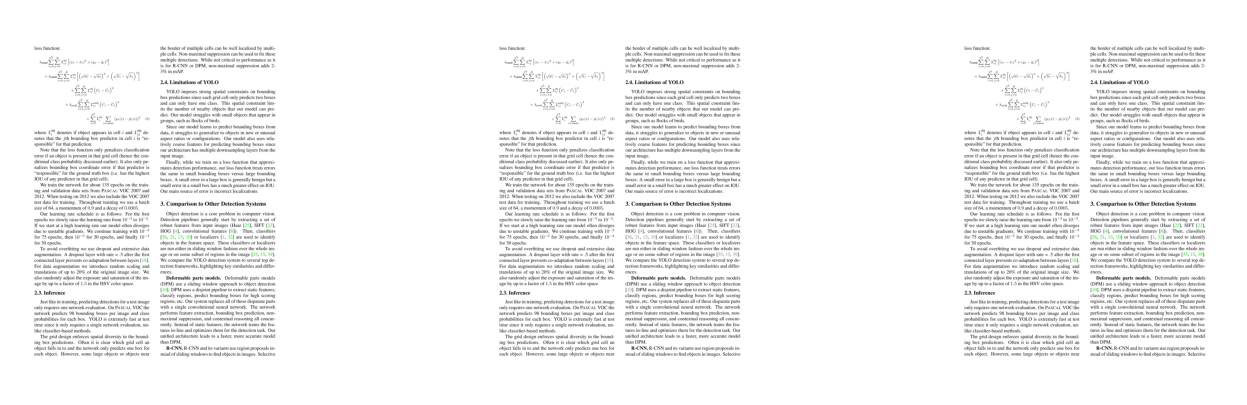

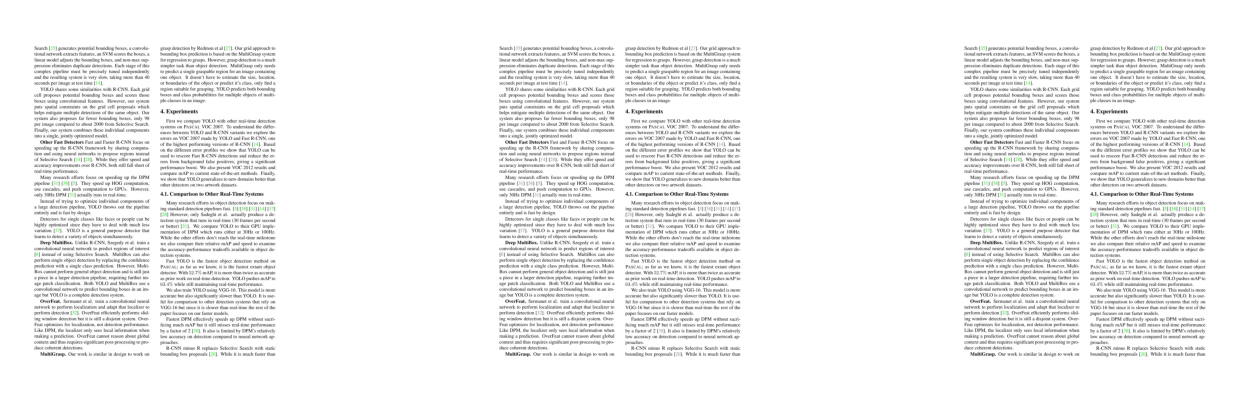

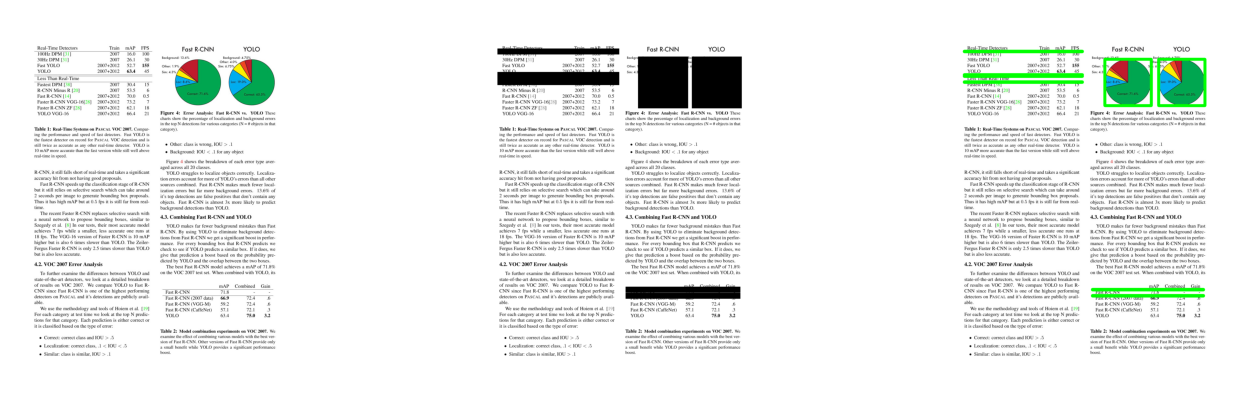

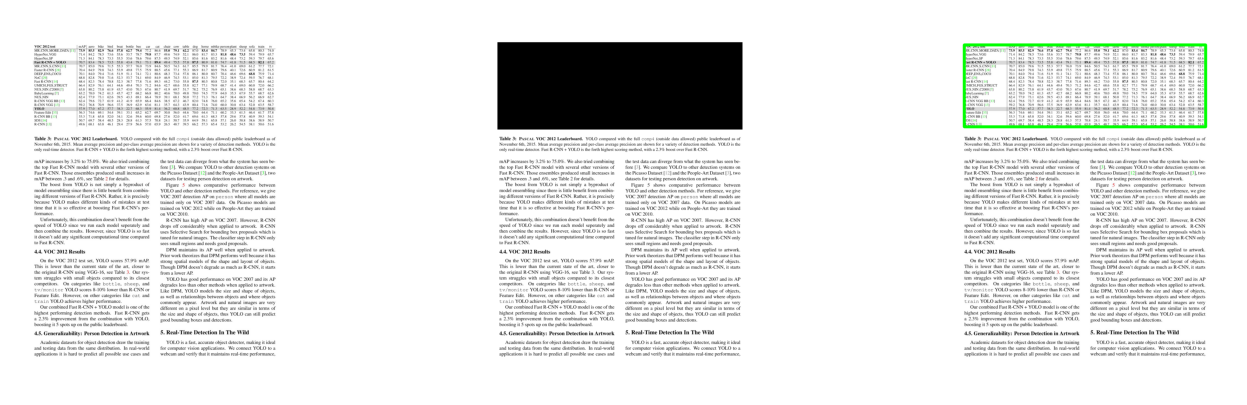

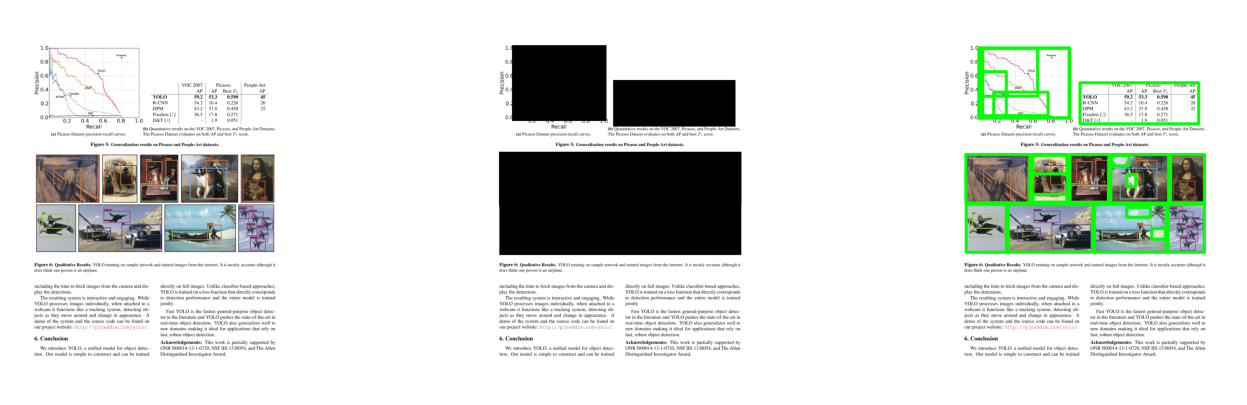

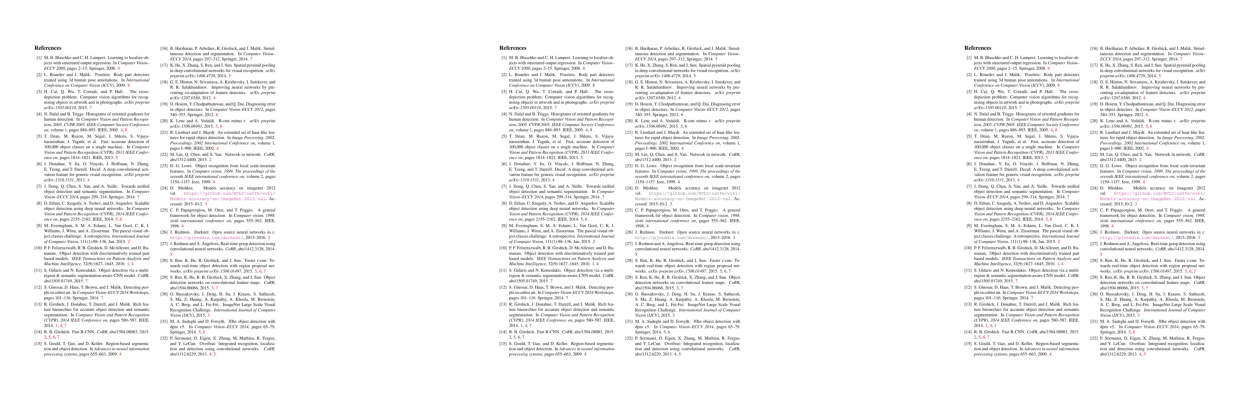

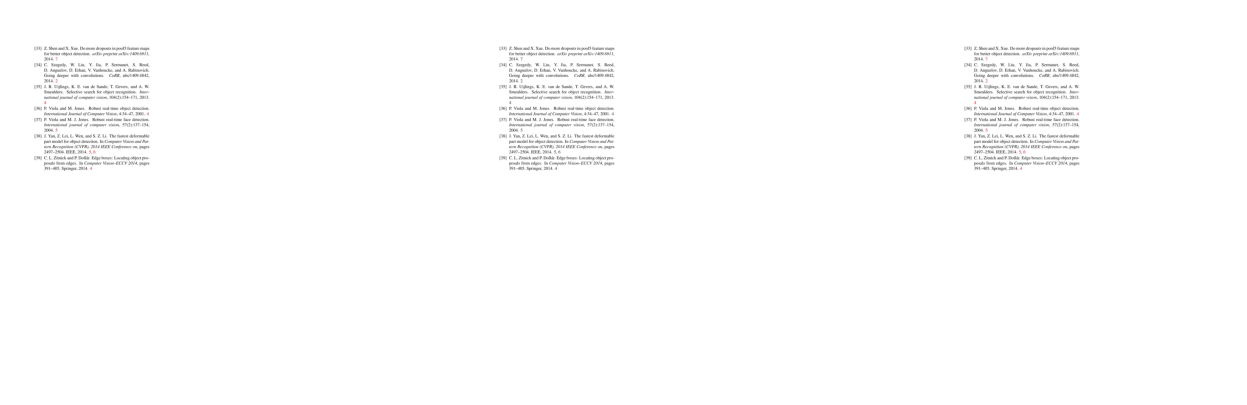

In [5]:
for idx, _ in enumerate(pages):

    image, rect = get_masked_page(pages[idx], True)
    show_pages([pages[idx], image, rect])

In [6]:
reader      = get_reader('en', True)
image, rect = get_masked_page(pages[0], True)

In [7]:
text = read_text(image)
print(f'{text}\n\n')

translate = naver_translate(text)
translate

You Only Look Once: Unified, Real-Time Object Detection Joseph Redmon Santosh Divvala*t Ross GirshickT Ali Farhadi*t University of Washington Allen Institute for AIt _ Facebook AI Research " http: / /pjreddie _ com yolo/ Abstract We present YOLO, a new approach to object detection Prior work on object detection repurposes classifiers to per- form detection. Instead, we frame object detection as a re - gression problem to spatially separated bounding boxes and associated class probabilities single neural network pre - Figure I: The YOLO Detection System_ Processing images dicts bounding boxes and class probabilities directly from with YOLO is simple and straightforward: Our system (1) resizes images in one evaluation. Since the whole detection the input image to 448 X 448, (2) runs a single convolutional net- 0) pipeline is a single network, it can be optimized end-to-end work on the image, and (3) thresholds the resulting detections by directly on detection performance. the model's con

'You Only Look Once: Unified, Real-Time Object Detection Joseph Redmon Santosh Divvala*t Ross GirshickT Ali Farhadi*t University of Washington Allen Institute for AIT _ Facebook AI Research " http: /pjreddie _ comyolo/ Abstract We present YOLO, 객체 검출에 대한 새로운 접근법 객체 검출에 대한 선행 작업은 검출을 수행하기 위해 분류기를 용도 변경한다.대신, 우리는 객체 검출을 공간적으로 분리된 바운딩 박스 및 관련 클래스 확률 단일 신경망에 대한 회귀 문제로 프레임화한다 - 그림 I: 욜로 검출 시스템_ 바운딩 박스 및 클래스 확률을 욜로에서 직접 처리하는 것은 단순하고 간단하다: 우리의 시스템(1)은 하나의 평가에서 이미지의 크기를 조정한다.448 X 448로의 입력 이미지의 전체 검출은 (2) 단일 컨볼루션 net-0) 파이프라인을 실행하기 때문에, 이미지에 대한 종단간 작업을 최적화할 수 있고, (3) 검출 성능에 직접적으로 의존함으로써 결과적인 검출을 임계화한다. 모델의 자신감 통합 아키텍처는 매우 빠릅니다: 우리의 기본 욜로 모델은 초당 45프레임으로 실시간으로 영상을 처리한다.네트워크의 작은 버전; Fast YOLO, 이미지에서 먼저 잠재적 경계 상자를 생성하고 이 제안된 상자에서 분류기를 실행하는 방법. 분류하는 동안 초당 155 프레임을 처리한 후, 후처리를 사용하여 경계를 세분화하고 여전히 다른 실시간 탐지 상자의 mAP를 두 배로 달성하며 중복 탐지를 제거하고 탐지기를 다시 점수화한다.최첨단 검출 시스템과 비교하여, YOLO는 더 많은 로컬라이제이션 에러를 발생시키지만 장면 내의 다른 객체들에 기초하여 박스들을 예측할 가능성은 낮다[13]. 이러한 복잡한 파이프라인은 각각의 배경 위의 위양성들 때문에 느리고 최적화하기 어렵다. 마지막으로, YOLO는 매